In [ ]:
#from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
#from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf
import numpy as np
import hydra
import os
#os.environ['SLURM_NTASKS_PER_NODE'] = '1'
#torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

val = hydra.utils.instantiate(
    cfg.experiment.val_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=1,
    shuffle=False,
    num_workers=1
)
import pickle
import io
ensembles = []
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

for i in range(0,4):
   # ensembles.append(CPU_Unpickler(open(f'../{i}_rollout_v_predictions_30year_ssp_585_20e12882_50steps_fixed_velocity.pkl', 'rb')).load())
    ensembles.append(CPU_Unpickler(open(f'../{i}_rollout.pkl', 'rb')).load())

num_steps = len(ensembles[0]['state_surface'])
# fixed = CPU_Unpickler(open(f'../0_rollout_v_predictions_30year_ssp_585_20e12882_50steps_fixed.pkl', 'rb')).load()



In [59]:
#LOAD BATCH DATA
ipsl_ensemble = []
batch_timeseries = {'state_surface':[]}
batch_iter = iter(val_dataloader)
val.timestamps
num_members = 3
for b in range((118 * num_members) + 1):
    if(b % 118 == 0 and b != 0):
        batch_timeseries['state_surface'] = np.stack(batch_timeseries['state_surface'])
        ipsl_ensemble.append(batch_timeseries)
        batch_timeseries = {'state_surface':[]}
    batch = next(batch_iter)
    print(batch['time'])
    batch_timeseries['state_surface'].append(batch['state_surface'])
ipsl_ensemble = np.stack(ipsl_ensemble)

['2001-02']
['2001-03']
['2001-04']
['2001-05']
['2001-06']
['2001-07']
['2001-08']
['2001-09']
['2001-10']
['2001-11']
['2001-12']
['2002-01']
['2002-02']
['2002-03']
['2002-04']
['2002-05']
['2002-06']
['2002-07']
['2002-08']
['2002-09']
['2002-10']
['2002-11']
['2002-12']
['2003-01']
['2003-02']
['2003-03']
['2003-04']
['2003-05']
['2003-06']
['2003-07']
['2003-08']
['2003-09']
['2003-10']
['2003-11']
['2003-12']
['2004-01']
['2004-02']
['2004-03']
['2004-04']
['2004-05']
['2004-06']
['2004-07']
['2004-08']
['2004-09']
['2004-10']
['2004-11']
['2004-12']
['2005-01']
['2005-02']
['2005-03']
['2005-04']
['2005-05']
['2005-06']
['2005-07']
['2005-08']
['2005-09']
['2005-10']
['2005-11']
['2005-12']
['2006-01']
['2006-02']
['2006-03']
['2006-04']
['2006-05']
['2006-06']
['2006-07']
['2006-08']
['2006-09']
['2006-10']
['2006-11']
['2006-12']
['2007-01']
['2007-02']
['2007-03']
['2007-04']
['2007-05']
['2007-06']
['2007-07']
['2007-08']
['2007-09']
['2007-10']
['2007-11']
['2007-12']
['20

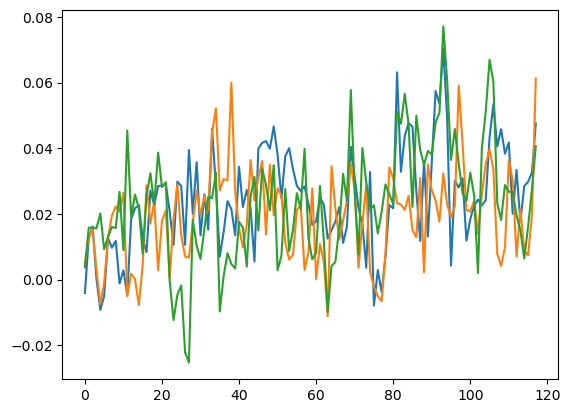

In [60]:
#verify batches 
import matplotlib.pyplot as plt
for i in ipsl_ensemble:
    plt.plot(np.nanmean(i['state_surface'][:,0,0],axis=(-1,-2)))

In [47]:
batch_denormed = []
denormed_ensembles = []
denormed_batch_ensembles = []
for i in range(3):
    month_index = 0
    denormalized = []
    batch_denormed = []
    for index in range(num_steps-6):
   # for index in range(len(ensembles[i]['state_surface'])-2):
        denorm_surface = lambda x,month_index: x*torch.from_numpy(train.surface_stds[month_index]) + torch.from_numpy(train.surface_means[month_index])
        denormalized.append(denorm_surface(ensembles[i]['state_surface'][index],month_index))
        batch_denormed.append(denorm_surface(torch.Tensor(ipsl_ensemble[i]['state_surface'][index]),month_index))
        if(month_index == 11):
            month_index = 0
        else:
            month_index += 1
    denormed_ensembles.append(denormalized)
    denormed_batch_ensembles.append(batch_denormed)


# for i in ensemble0['state_surface']:
#     print(i.shape)

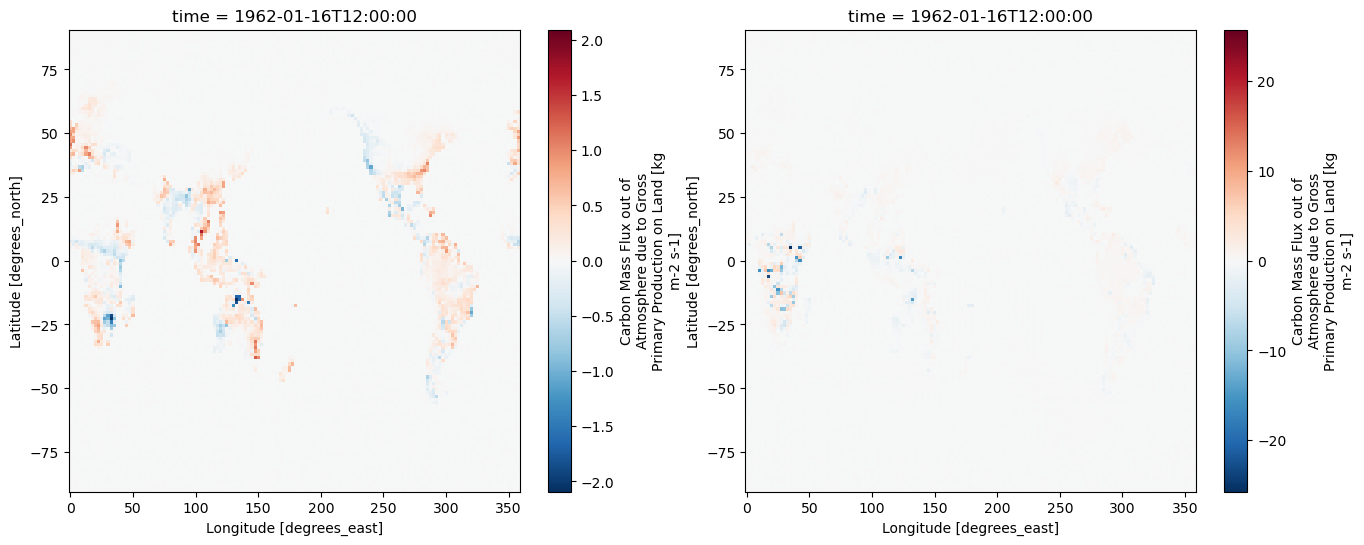

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
#shell[var_name].data = steps[49][0,0,0]
shell[var_name].data = ensembles[0]['state_surface'][0][0][3]
shell[var_name].plot.pcolormesh(ax=ax1)
shell[var_name].data = ensembles[-1]['state_surface'][-1][0][3]
shell[var_name].plot.pcolormesh(ax=ax2)

MovieWriter ffmpeg unavailable; using Pillow instead.


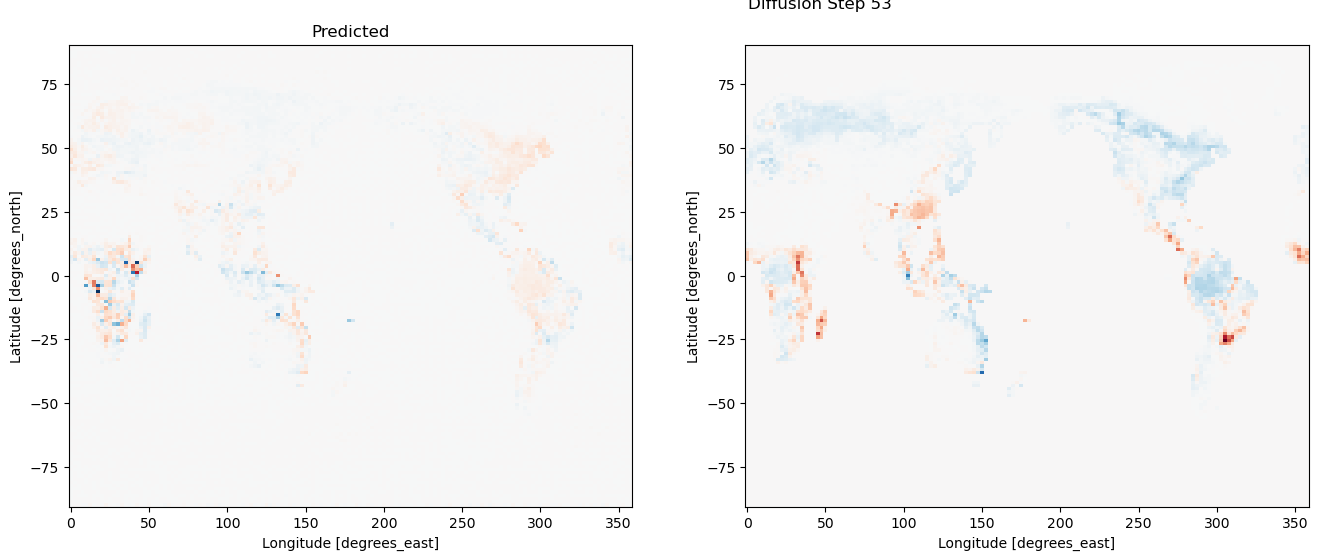

In [43]:
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np

var_index = 4
fig, axes = plt.subplots(1,2, figsize=(16, 6))
axes = axes.flatten()
container = []
for time_step in range(num_steps-6):
    shell['tas'].data = np.stack(ensembles[0]['state_surface'])[time_step][0][var_index]
   # line = ax1.pcolormesh(steps[time_step][0,0,0])
    line = shell['tas'].plot.pcolormesh(ax=axes[0],add_colorbar=False)
    shell['tas'].data = np.stack(ipsl_ensemble[0]['state_surface'])[time_step][0][var_index]
    line1 = shell['tas'].plot.pcolormesh(ax=axes[1],add_colorbar=False)
    title = axes[0].text(0.5,1.05,"Diffusion Step {}".format(time_step), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax1.transAxes,)
    axes[0].set_title('Predicted')
    axes[1].set_title('IPSL')

    container.append([line, line1,title])
plt.title('')

ani = animation.ArtistAnimation(fig, container, interval=200, blit=True)
ani.save("diffusion_comparison_.gif")

Text(0, 0.5, 'Normalized Value')

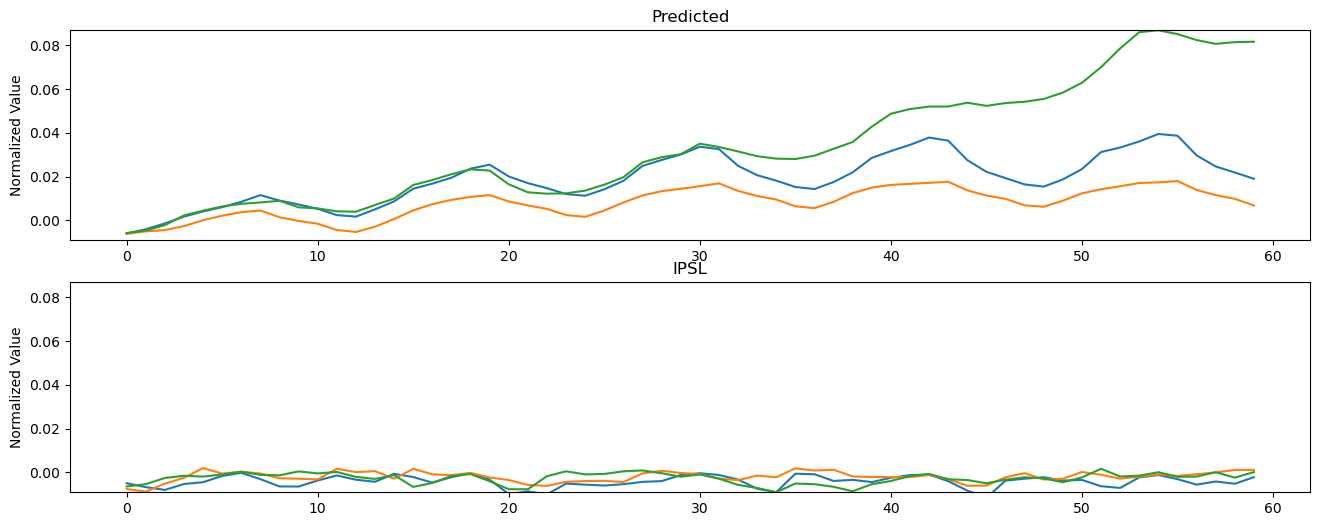

In [68]:
import numpy as np
fig, axes = plt.subplots(2, figsize=(16, 6))
axes = axes.flatten()
var = 6
for i in ensembles:
    axes[0].plot(np.mean(np.stack(i['state_surface'])[:num_steps,0,var],axis=(-1,-2)))
min = np.mean(np.stack(i['state_surface'])[:num_steps,0,var],axis=(-1,-2)).min()
max = np.mean(np.stack(i['state_surface'])[:num_steps,0,var],axis=(-1,-2)).max()
import matplotlib.pyplot as plt
for i in np.stack(ipsl_ensemble):
    axes[1].plot(np.nanmean(i['state_surface'][:num_steps,0,var],axis=(-1,-2)))
min = min if min < np.mean(np.stack(i['state_surface'])[:num_steps,0,var],axis=(-1,-2)).min() else np.mean(np.stack(i['state_surface'])[:num_steps,0,var],axis=(-1,-2)).min()
max = max if max > np.mean(np.stack(i['state_surface'])[:num_steps,0,var],axis=(-1,-2)).max() else np.mean(np.stack(i['state_surface'])[:num_steps,0,var],axis=(-1,-2)).max()
axes[0].set_ylim(min,max)
axes[1].set_ylim(min,max)
axes[0].set_title('Predicted')
axes[1].set_title('IPSL')
axes[0].set_ylabel('Normalized Value')
axes[1].set_ylabel('Normalized Value')


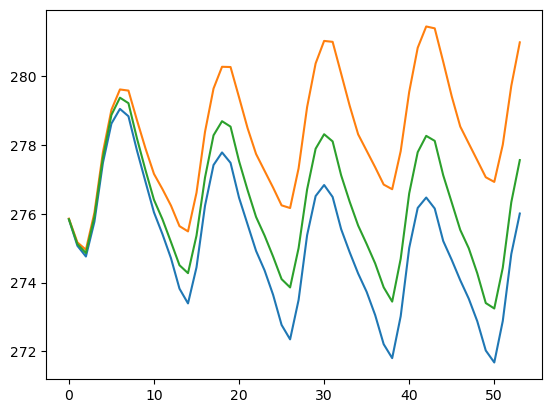

In [48]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,0],axis=(-1,-2)))

In [ ]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_batch_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,0],axis=(-1,-2)))

In [ ]:
pred = np.stack(denormalized)
plt.plot(np.nanmean(pred[:,0,0],axis=(-1,-2)),label='pred')
plt.plot(np.nanmean(np.stack(batch_denormed)[:,0,0],axis=(-1,-2)),label='true')
plt.legend()

In [ ]:
#get 30 year trend from batch 
import xarray as xr 
#just manually open 3 files to check and compare trend
scratch = os.environ['SCRATCH']
var_name = 'tas'
data = []
files = [f'{scratch}/1996_1.nc',f'{scratch}/2006_1.nc',f'{scratch}/2016_1.nc']
for file in files: 
    data.append(xr.open_dataset(file)[var_name])
    
concated = xr.concat(data,dim='time')
concated.mean(dim=['lat','lon']).plot()

In [ ]:
var = 0
plt.plot(np.mean(np.stack(fixed['state_surface'])[:118,0,var],axis=(-1,-2)),label='pred')
plt.plot(np.mean(ipsl_ensemble[:118,0,var],axis=(-1,-2)),label='ipsl')
plt.legend()


In [5]:
batch = next(iter(train_dataloader))
model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=val_dataloader.dataset
)

file_name = 'epoch=45.ckpt'
#scratch = os.environ['SCRATCH']
#checkpoint_path = torch.load(f'{scratch}/checkpoint_{run_id}/{file_name}',map_location=torch.device('cuda'))
checkpoint_path = torch.load(f'../epoch=45.ckpt',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint_path['state_dict'])

NameError: name 'train_dataloader' is not defined

In [ ]:
batch['time']

In [ ]:
sample,steps = model.sample(batch, denormalize=False,num_inference_steps=100,scheduler='ddpm',seed=0)


In [ ]:
fig, axes = plt.subplots(100, figsize=(6, 306))
axes = axes.flatten()
for i in range(len(steps)): 
    shell['tas'].data = steps[i][0][0]
    #shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
   # line = ax1.pcolormesh(steps[time_step][0,0,0])
    shell['tas'].plot.pcolormesh(ax=axes[i],add_colorbar=True)


NameError: name 'batch' is not defined

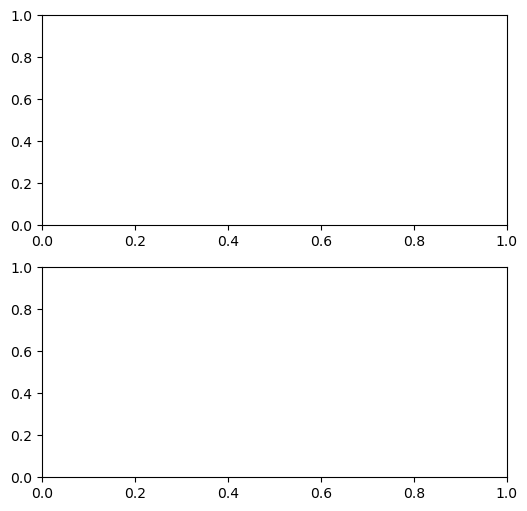

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, figsize=(6, 6))
axes = axes.flatten()
shell['tas'].data = batch['next_state_surface'][0][3]
#shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
# line = ax1.pcolormesh(steps[time_step][0,0,0])
shell['tas'].plot.pcolormesh(ax=axes[0],add_colorbar=True)
shell['tas'].data = sample['next_state_surface'][0][3]
#shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
# line = ax1.pcolormesh(steps[time_step][0,0,0])
shell['tas'].plot.pcolormesh(ax=axes[1],add_colorbar=True)
batch['next_state_surface'][0][3].min()
axes.set_ylim(batch['next_state_surface'][0][3].min(),batch['next_state_surface'][0][3].max())

In [ ]:
fig, axes = plt.subplots(1, figsize=(6, 6))

shell['tas'].data = sample['next_state_surface'][0][0]
#shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
# line = ax1.pcolormesh(steps[time_step][0,0,0])
shell['tas'].plot.pcolormesh(ax=axes,add_colorbar=True)

In [ ]:
fig, axes = plt.subplots(1, figsize=(6, 6))

shell['tas'].data = (batch['state_surface'][0][0]-(sample['next_state_surface'][0][0]*.1))
#shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
# line = ax1.pcolormesh(steps[time_step][0,0,0])
shell['tas'].plot.pcolormesh(ax=axes,add_colorbar=True)

In [ ]:
fig, axes = plt.subplots(1, figsize=(6, 6))
# batch['next_state_surface'] = ((batch['next_state_surface']*self.surface_delta_stds.to(device).unsqueeze(0)) + batch['state_surface'])

shell['tas'].data = ((sample['next_state_surface'] * train.surface_delta_stds.unsqueeze(0)) + batch['state_surface'])[0][0]
#shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
# line = ax1.pcolormesh(steps[time_step][0,0,0])
shell['tas'].plot.pcolormesh(ax=axes,add_colorbar=True)